# Annotations to masks workflow

**Overview:** 

This includes tools to parse annotations from an item (slide) into masks to use in training and evaluating imaging algorithms. Two "versions" of this workflow exist:

- Get labeled mask for any region in a whole-slide image (user-defined)

- Get labeled mask for areas enclosed within special "region-of-interest" (ROI) annotations that have been drawn by the user. This involves mapping annotations (rectangles/polygons) to ROIs and making one mask per ROI.

This extends on some of the workflows described in Amgad et al, 2019:

__Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, 2019, btz083__


This slide used as a test example:  

[TCGA-A2-A0YE-01Z-00-DX1](http://candygram.neurology.emory.edu:8080/histomicstk#?image=5d586d57bd4404c6b1f28640&bounds=53566%2C33193%2C68926%2C40593%2C0 )

The user uses a csv file like the one in 
```histomicstk/annotations_and_masks/tests/test_files/sample_GTcodes.csv ```
to control pixel values assigned to mask, overlay order of various annotation groups, which groups are considered to be ROIs, etc. Note that we use the girder definition of term "group" here, which is an annotation style indicating a certain class, such as "tumor" or "necrosis".

**Why is this needed?**

This adds a lot of functionality on top of API endpoints that get annotations as a list of dictionaries, including handing the following complex situations:

- Getting RGB images and labeled masks at the same magnification/resolution

- User-defined regions to get, including "cropping" of annotations to desired bounds

- Getting user-drawn ROIs, including rotated rectangles and polygons

- Overlapping annotations

- "Background" class (eg. anything not-otherwise-specified is stroma)

- Getting contours and bounding boxes relative to images at the same resolution, to be used to trainign object localization models like Faster-RCNN. 

**Where to look?**

```
|_ histomicstk/
|   |_annotations_and_masks/
|      |_annotation_and_mask_utils.py
|      |_annotations_to_masks_handler.py 
|_ plugin_tests/
    |_annotations_and_masks/
    |  |_annotation_and_mask_utils_test.py
    |  |_annotations_to_masks_handler_test.py
    |_test_files/
       |_sample_GTcodes.csv 
```

In [2]:
import os
import sys

import girder_client
from pandas import DataFrame, read_csv
import tempfile
import shutil
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline

from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_bboxes_from_slide_annotations, _get_idxs_for_all_rois,
    scale_slide_annotations, get_scale_factor_and_appendStr)
from histomicstk.annotations_and_masks.annotations_to_masks_handler import (
    get_roi_mask, get_image_and_mask_from_slide, get_all_rois_from_slide)

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 7, 7
titlesize = 16

## Constants and prepwork

In [3]:
CWD = os.getcwd()

APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = '5d586d57bd4404c6b1f28640'
GTCODE_PATH = os.path.join(
    CWD, '../../histomicstk/annotations_and_masks/tests/test_files/sample_GTcodes.csv')

# connect to girder client
gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# just a temp directory to save masks for now
BASE_SAVEPATH = tempfile.mkdtemp()
SAVEPATHS = {
    'ROI': os.path.join(BASE_SAVEPATH, 'masks'),
    'rgb': os.path.join(BASE_SAVEPATH, 'rgbs'),
    'contours': os.path.join(BASE_SAVEPATH, 'contours'),
    'visualization': os.path.join(BASE_SAVEPATH, 'vis'),
}
for _, savepath in SAVEPATHS.items():
    os.mkdir(savepath)
    
# What resolution do we want to get the images at?
# Microns-per-pixel / Magnification (either or)
MPP = 2.5  # <- this roughly translates to 4x magnification
MAG = None

### Let's inspect the ground truth codes file

This contains the ground truth codes and information dataframe.
This is a dataframe that is indexed by the annotation group name and
has the following columns:

- ```group```: group name of annotation (string), eg. "mostly_tumor"
- ```overlay_order```: int, how early to place the annotation in the
    mask. Larger values means this annotation group is overlayed
    last and overwrites whatever overlaps it.
- ```GT_code```: int, desired ground truth code (in the labeled mask)
    Pixels of this value belong to corresponding group (class)
- ```is_roi```: Flag for whether this group marks 'special' annotations that encode the ROI boundary
- ```is_background_class```: Flag, whether this group is the default
    fill value inside the ROI. For example, you may descide that
    any pixel inside the ROI is considered stroma.
    
**IMPORTANT NOTE:** 

Zero pixels have special meaning and do NOT encode specific ground truth class. Instead, they simply
mean 'Outside ROI' and should be IGNORED during model training or evaluation.

In [4]:
# read GTCodes file
GTCodes = read_csv(GTCODE_PATH)
GTCodes.index = GTCodes.loc[:, 'group']

In [5]:
GTCodes

,group,overlay_order,GT_code,is_roi,is_background_class,color,comments
group,,,,,,,
roi,roi,0,254,1,0,"rgb(200,0,150)",NaN
evaluation_roi,evaluation_roi,0,253,1,0,"rgb(255,0,0)",NaN
mostly_tumor,mostly_tumor,1,1,0,0,"rgb(255,0,0)",core class
mostly_stroma,mostly_stroma,2,2,0,1,"rgb(255,125,0)",core class
mostly_lymphocytic_infiltrate,mostly_lymphocytic_infiltrate,1,3,0,0,"rgb(0,0,255)",core class
necrosis_or_debris,necrosis_or_debris,1,4,0,0,"rgb(255,255,0)",core class
glandular_secretions,glandular_secretions,1,5,0,0,"rgb(0,255,0)",secondary class
mostly_blood,mostly_blood,1,6,0,0,"rgb(128,0,128)",secondary class
exclude,exclude,3,7,0,0,"rgb(0,0,0)",secondary class


## Get region within any bounds (RGB / mask / contours)

### This is the core method you'll want to use

In [6]:
print(get_image_and_mask_from_slide.__doc__)

Parse region from the slide and get its corresponding labeled mask.
    This is a wrapper around get_roi_mask() which should be referred to for
    implementation details.

    Parameters
    -----------
    gc : object
        girder client object to make requests, for example:
        gc = girder_client.GirderClient(apiUrl = APIURL)
        gc.authenticate(interactive=True)

    slide_id : str
        girder id for item (slide)

    GTCodes_dict : dict
        the ground truth codes and information dict.
        This is a dict that is indexed by the annotation group name and
        each entry is in turn a dict with the following keys:
        - group: group name of annotation (string), eg. mostly_tumor
        - overlay_order: int, how early to place the annotation in the
        mask. Larger values means this annotation group is overlayed
        last and overwrites whatever overlaps it.
        - GT_code: int, desired ground truth code (in the mask)
        Pixels of this value be

### More input parameters

In [7]:
# other params
get_roi_mask_kwargs = {
    'iou_thresh': 0.0,
    'crop_to_roi': True,
    'use_shapely': True,
    'verbose': False
}
get_contours_kwargs = {
    'groups_to_get': None,
    'roi_group': 'roi',
    'get_roi_contour': True,
    'discard_nonenclosed_background': True,
    'background_group': 'mostly_stroma',
    'MIN_SIZE': 10, 'MAX_SIZE': None,
    'verbose': False, 'monitorPrefix': ""
}

# params for get_image_and_mask_from_slide()
get_kwargs = {
    'gc': gc, 'slide_id': SAMPLE_SLIDE_ID,
    'GTCodes_dict': GTCodes.T.to_dict(),
    'MPP': MPP,
    'MAG': MAG,
    'get_roi_mask_kwargs': get_roi_mask_kwargs,
    'get_contours_kwargs': get_contours_kwargs,
    'get_rgb': True,
    'get_contours': True,
    'get_visualization': True,
}

### 1. manual_bounds mode

As you've seen in documentation, this method has four run modes, which determines where to get
labeled masks and other behaviours. Here we test the basic 'manual_bounds' mode, where you just ive the boundaries (at base/scan magnification) of the annotations you want. Of course
everything will be scaled to the desired resolution. 

In [8]:
get_kwargs['bounds'] = {
    'XMIN': 58000, 'XMAX': 63000,
    'YMIN': 35000, 'YMAX': 39000
}

In [9]:
# get specified region, let the method get and scale annotations
roi_out = get_image_and_mask_from_slide(mode='manual_bounds', **get_kwargs)

The result is an rgb image, labeled mask, contours and a visualization. Let's take a look at these below.'

In [10]:
roi_out.keys()

dict_keys(['bounds', 'ROI', 'rgb', 'contours', 'visualization'])

In [11]:
roi_out['bounds']

{'XMAX': 63000, 'XMIN': 58000, 'YMAX': 39000, 'YMIN': 35000}

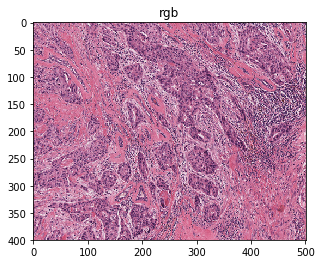

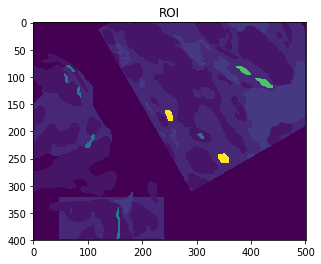

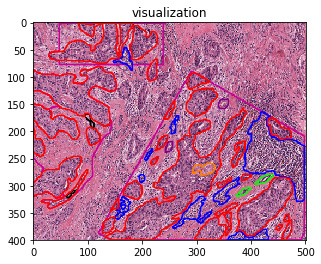

In [12]:
for imstr in ['rgb', 'ROI', 'visualization']:
    plt.imshow(roi_out[imstr])
    plt.title(imstr)
    plt.show()

In [13]:
DataFrame(roi_out['contours']).head()

,color,coords_x,coords_y,group,has_holes,touches_edge-bottom,touches_edge-left,touches_edge-right,touches_edge-top,xmax,xmin,ymax,ymin
0,"rgb(200,0,150)","214,212,212,211,211,210,210,211,211,212,212,21...","292,294,295,296,299,300,310,311,313,314,315,31...",roi,0.0,0.0,0.0,0.0,0.0,243.0,29.0,398.0,292.0
1,"rgb(200,0,150)","31,30,29,27,27,28,29,30,30,29,22,21,16,15,15,1...","57,58,58,60,64,65,65,66,67,68,68,69,69,70,71,7...",roi,1.0,0.0,1.0,0.0,0.0,153.0,0.0,319.0,57.0
2,"rgb(200,0,150)","142,141,140,138,137,136,135,134,133,131,130,12...","0,1,1,3,3,4,4,5,5,7,7,8,8,10,10,11,11,12,12,13...",roi,0.0,0.0,0.0,0.0,1.0,498.0,120.0,309.0,0.0
3,"rgb(128,0,128)","349,348,343,342,340,340,341,341,343,343,346,35...","241,242,242,243,243,250,251,252,254,255,258,25...",blood_vessel,0.0,0.0,0.0,0.0,0.0,358.0,340.0,258.0,241.0
4,"rgb(128,0,128)","243,243,244,244,245,245,246,246,248,248,256,25...","161,167,168,171,172,174,175,177,179,180,180,17...",blood_vessel,0.0,0.0,0.0,0.0,0.0,256.0,243.0,180.0,161.0


Note that if we were to use the above function call repeatedly for the same slide
(eg to get tiles or multiple regions of interest), this would repeatedly use a 
get request to obtain the annotations from the server, which is inefficient. Instead,
if we know we'll be using this repeatedly for the same slide, we manually get annotations
and scale them down/up to desired resolution, and pass them to `get_image_and_mask_from_slide()`
method. Here's how this could be done. 

In [14]:
# get annotations for slide
slide_annotations = gc.get('/annotation/item/' + SAMPLE_SLIDE_ID)

# scale up/down annotations by a factor
sf, _ = get_scale_factor_and_appendStr(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, MPP=MPP, MAG=MAG)
slide_annotations = scale_slide_annotations(slide_annotations, sf=sf)

# get bounding box information for all annotations
element_infos = get_bboxes_from_slide_annotations(slide_annotations)

In [15]:
# get specified region -- manually providing scaled annotations
roi_out = get_image_and_mask_from_slide(
    mode='manual_bounds', slide_annotations=slide_annotations,
    element_infos=element_infos, **get_kwargs)

In [16]:
roi_out['bounds']

{'XMAX': 63000, 'XMIN': 58000, 'YMAX': 39000, 'YMIN': 35000}

### 2. min_bounding_box mode

If you don't care about any "special" ROI annotations and would just like to parse everything in the
slide into a 'super' minimum-bounding-box labeled mask, use the `min_bounding_box` mode as follows.

In [17]:
# get ROI bounding everything
minbbox_out = get_image_and_mask_from_slide(
    mode='min_bounding_box', slide_annotations=slide_annotations,
    element_infos=element_infos, **get_kwargs)

In [18]:
minbbox_out['bounds']

{'XMAX': 63742, 'XMIN': 56736, 'YMAX': 39900, 'YMIN': 33493}

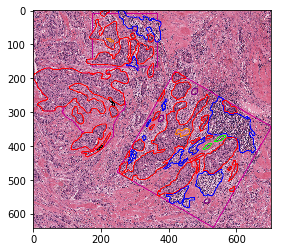

In [19]:
plt.imshow(minbbox_out['visualization'])

### 3. wsi mode
If you just want a miniature version of the slide and all its annotations, usine this mode.

In [20]:
# get entire wsi region
get_kwargs['MPP'] = 5.0  # otherwise it's too large!
wsi_out = get_image_and_mask_from_slide(
    mode='wsi', **get_kwargs)

In [21]:
wsi_out['bounds']

{'XMAX': 131536, 'XMIN': 0, 'YMAX': 80453, 'YMIN': 0}

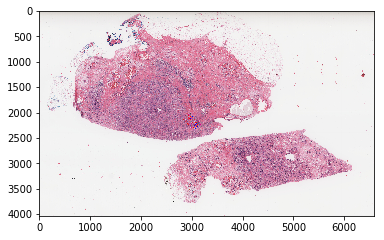

In [22]:
plt.imshow(wsi_out['visualization'])
plt.show()

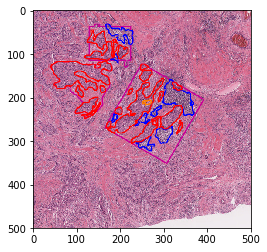

In [23]:
plt.imshow(wsi_out['visualization'][2000:2500, 2800:3300])
plt.show()

## Parse manually-drawn ROIs into separate labeled masks

### This is the core method you'll want to use

This utilizes the __polygonal_bounds__ mode of the `get_image_and_mask_from_slide()` method.

In [24]:
print(get_all_rois_from_slide.__doc__)

Parse annotations and saves ground truth masks for ALL ROIs.

    Get all ROIs in a single slide. This is mainly uses
    get_image_and_mask_from_slide(), which should be referred to
    for implementation details.

    Parameters
    -----------
    gc : object
        girder client object to make requests, for example:
        gc = girder_client.GirderClient(apiUrl = APIURL)
        gc.authenticate(interactive=True)

    slide_id : str
        girder id for item (slide)

    GTCodes_dict : dict
        the ground truth codes and information dict.
        This is a dict that is indexed by the annotation group name and
        each entry is in turn a dict with the following keys:
        - group: group name of annotation (string), eg. mostly_tumor
        - overlay_order: int, how early to place the annotation in the
        mask. Larger values means this annotation group is overlayed
        last and overwrites whatever overlaps it.
        - GT_code: int, desired ground truth code (i

In [25]:
detailed_kwargs = {
    'MPP': MPP,
    'MAG': None,
    'get_roi_mask_kwargs': get_roi_mask_kwargs,
    'get_contours_kwargs': get_contours_kwargs,
    'get_rgb': True,
    'get_contours': True,
    'get_visualization': True,
}

The parameter ```get_roi_mask_kwargs``` (which is one of the keys of the parameter ```get_image_and_mask_from_slide_kwargs```) is a dictionary of ```kwargs``` that is eventually passed on to ```get_roi_mask()```. Watchout for the following parameters:

- ```crop_to_roi``` - flag of whether to crop polygons to roi (prevent 'overflow' beyond roi edge)

- ```use_shapely``` - flag of whether to precisely determine whether an element
    belongs to an ROI using shapely polygons. Ever-so-slightly slower. If
    set to False, overlapping bounding box is used as a cheap but
    less precise indicator of inclusion.

In [26]:
savenames = get_all_rois_from_slide(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, GTCodes_dict=GTCodes.T.to_dict(),
    save_directories=SAVEPATHS,
    get_image_and_mask_from_slide_kwargs=detailed_kwargs,
    slide_name='TCGA-A2-A0YE', verbose=False)

In [27]:
savenames[0]

{'ROI': 'C:\\Users\\tageldim\\AppData\\Local\\Temp\\tmp1pjuvtxw\\masks\\TCGA-A2-A0YE_left-59201_top-33493_bottom-63742_right-38093.png',
 'contours': 'C:\\Users\\tageldim\\AppData\\Local\\Temp\\tmp1pjuvtxw\\contours\\TCGA-A2-A0YE_left-59201_top-33493_bottom-63742_right-38093.csv',
 'rgb': 'C:\\Users\\tageldim\\AppData\\Local\\Temp\\tmp1pjuvtxw\\rgbs\\TCGA-A2-A0YE_left-59201_top-33493_bottom-63742_right-38093.png',
 'visualization': 'C:\\Users\\tageldim\\AppData\\Local\\Temp\\tmp1pjuvtxw\\vis\\TCGA-A2-A0YE_left-59201_top-33493_bottom-63742_right-38093.png'}

### Let's visualize the ROIs created

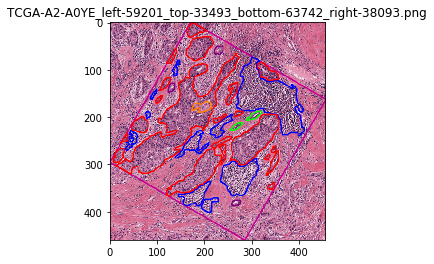

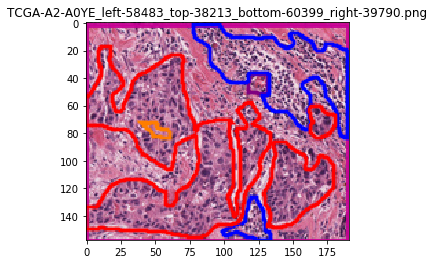

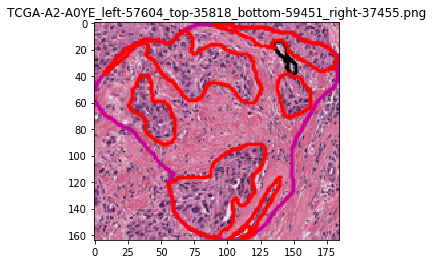

In [28]:
for savename in savenames:
    vis = imread(savename["visualization"])
    plt.imshow(vis)
    plt.title(os.path.basename(savename["visualization"]))
    plt.show()

## [EXTRA] - Explore some of the inner workings

### Core method being called to get a specific ROI from a slide

In [29]:
print(get_roi_mask.__doc__)

Parse annotations and gets a ground truth mask for a single ROI.

    This will look at all slide annotations and get ones that
    overlap with the region of interest (ROI) and assigns them to mask.

    Parameters
    -----------
    slide_annotations : list of dicts
        response from server request
    element_infos : pandas DataFrame.
        The columns annidx and elementidx
        encode the dict index of annotation document and element,
        respectively, in the original slide_annotations list of dictionaries.
        This can be obain by get_bboxes_from_slide_annotations() method
    GTCodes_df : pandas Dataframe
        the ground truth codes and information dataframe.
        This is a dataframe that is indexed by the annotation group name and
        has the following columns:
        - group: group name of annotation (string), eg. mostly_tumor
        - overlay_order: int, how early to place the annotation in the
        mask. Larger values means this annotation gro